# A Predictive Model for Credit Card Default

By: Aaron Yang

## Table of contents
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. [Your takeaway from the course](#14)

## Introduction<a name="1"></a>

Credit card default is a serious concern for banks because it affects how they manage risk and make lending decisions. In this project, I work with the [UCI Default of Credit Card Clients dataset](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data), which includes information on the payment history, personal details, and financial status of 30,000 credit card users in Taiwan from April to September 2005.

The goal is to build a model that can predict whether a customer will default on their credit card debt. This involves cleaning the data, exploring patterns, feature engineer, selecting useful features, and using supervised machine learning to make predictions.

### Variable information:

There are 25 variables:

- ID – Unique identifier for each client.  

- LIMIT_BAL – Total credit amount granted (in NT dollars), including both personal and supplementary/family credit.  

- SEX – Gender of the client (1 = male, 2 = female).  

- EDUCATION – Education level (1 = graduate school, 2 = university, 3 = high school, 4 = other, 5 = unknown, 6 = unknown).  

- MARRIAGE – Marital status (1 = married, 2 = single, 3 = other).  

- AGE – Client's age (in years).  

- PAY_0 – Repayment status in September 2005 (−1 = paid on time, 1 = one month delay, 2 = two months delay, ..., 8 = eight months delay, 9 = nine months or more delay).  

- PAY_2 – Repayment status in August 2005 (same scale as PAY_0).  

- PAY_3 – Repayment status in July 2005 (same scale as PAY_0).  

- PAY_4 – Repayment status in June 2005 (same scale as PAY_0).  

- PAY_5 – Repayment status in May 2005 (same scale as PAY_0).  

- PAY_6 – Repayment status in April 2005 (same scale as PAY_0).  

- BILL_AMT1 – Bill statement amount in September 2005 (NT dollars).  

- BILL_AMT2 – Bill statement amount in August 2005 (NT dollars).  

- BILL_AMT3 – Bill statement amount in July 2005 (NT dollars).  

- BILL_AMT4 – Bill statement amount in June 2005 (NT dollars).  

- BILL_AMT5 – Bill statement amount in May 2005 (NT dollars).  

- BILL_AMT6 – Bill statement amount in April 2005 (NT dollars).  

- PAY_AMT1 – Amount paid in September 2005 (NT dollars).  

- PAY_AMT2 – Amount paid in August 2005 (NT dollars).  

- PAY_AMT3 – Amount paid in July 2005 (NT dollars).  

- PAY_AMT4 – Amount paid in June 2005 (NT dollars).  

- PAY_AMT5 – Amount paid in May 2005 (NT dollars).  

- PAY_AMT6 – Amount paid in April 2005 (NT dollars).  

- default.payment.next.month – Whether the client defaulted on the payment next month (1 = yes, 0 = no).  


## Objectives:
- Determine the primary factors influencing the probability of credit card default.

- Develop a predictive model to estimate the likelihood of credit card default among the Bank’s customers.


<!-- BEGIN QUESTION -->

## Imports

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 16

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split
)

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score
)

from sklearn.compose import make_column_transformer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import RFECV

from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
import shap


## Data Loading and Splitting<a name="2"></a>

In [67]:
card_dataset = pd.read_csv("UCI_Credit_Card.csv")
card_dataset.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [68]:
card_dataset.shape

(30000, 25)

The dataset contains records for 30,000 customers. We will split it into training (70%) and testing (30%) subsets using `random_state=123` to ensure reproducibility.

In [69]:
train_set, test_set = train_test_split(card_dataset, test_size = 0.3, random_state = 123, stratify = card_dataset["default.payment.next.month"])
train_set.shape

(21000, 25)

## Exploratory Data Analysis on the Train Set<a name="3"></a>
<hr>

The summary table indicates that there are no missing values, so imputation is unnecessary. Additionally, categorical features like MARRIAGE and EDUCATION have already been encoded as numerical values, although they require further inspection for interpretability.

In [70]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 14451 to 13416
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          21000 non-null  int64  
 1   LIMIT_BAL                   21000 non-null  float64
 2   SEX                         21000 non-null  int64  
 3   EDUCATION                   21000 non-null  int64  
 4   MARRIAGE                    21000 non-null  int64  
 5   AGE                         21000 non-null  int64  
 6   PAY_0                       21000 non-null  int64  
 7   PAY_2                       21000 non-null  int64  
 8   PAY_3                       21000 non-null  int64  
 9   PAY_4                       21000 non-null  int64  
 10  PAY_5                       21000 non-null  int64  
 11  PAY_6                       21000 non-null  int64  
 12  BILL_AMT1                   21000 non-null  float64
 13  BILL_AMT2                   2100

As shown below, the EDUCATION feature is already encoded numerically. However, since the meanings of values 0, 5, and 6 are undefined, we will group them under the value 4 ("others") during preprocessing.

In [71]:
pd.DataFrame(train_set["EDUCATION"]).value_counts()

EDUCATION
2            9875
1            7346
3            3451
5             194
4              90
6              32
0              12
Name: count, dtype: int64

The training set summary shows that the average client age is 35.5 years, with the majority having completed university. Additionally, there are more female than male clients, and a larger number of single clients compared to married ones. Due to significant differences in the scales of numerical features, feature scaling will be necessary prior to model training.

In [72]:
train_set.describe(include = "all")

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,14941.956190,167627.318095,1.602476,1.855762,1.551048,35.488476,-0.017429,-0.127810,-0.159238,-0.216095,...,43295.839476,40389.043095,38838.993143,5663.359190,5.990677e+03,5214.520762,4876.729810,4747.745952,5135.359143,0.221190
std,8655.884718,129860.863421,0.489398,0.787604,0.523430,9.224177,1.125270,1.199651,1.203743,1.174019,...,64297.470511,60866.714551,59587.880749,16612.876887,2.508848e+04,18035.872826,16423.808259,14813.761614,17679.532366,0.415058
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-28335.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7467.500000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2318.750000,1776.000000,1315.750000,1000.000000,8.557500e+02,390.000000,300.000000,278.750000,109.000000,0.000000
50%,14920.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19119.500000,18160.500000,17094.500000,2100.000000,2.010500e+03,1800.000000,1500.000000,1509.500000,1500.000000,0.000000
75%,22431.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54928.750000,50229.750000,49286.250000,5001.000000,5.000000e+03,4529.250000,4000.000000,4031.500000,4000.000000,0.000000
max,29999.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,7.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


Taking a closer look at the distribution of `default_payment_next_month`, there is a class imbalance in our target variable where the majority of clients do not default on their payment. Therefore, we will need to handle class imbalance during the training of the models. 

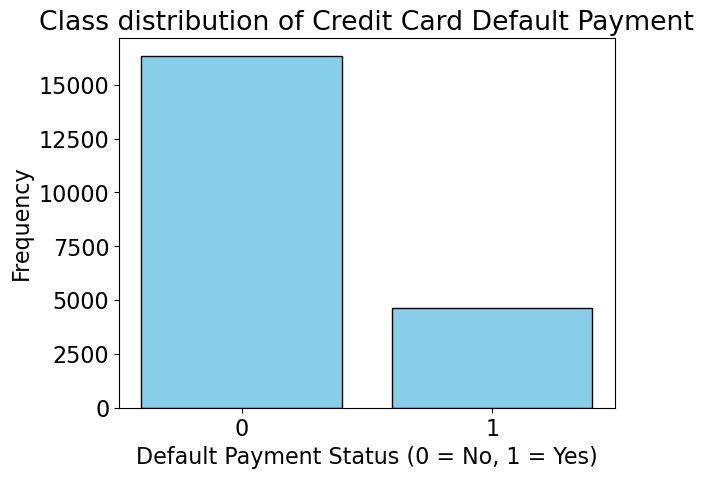

In [73]:
count = train_set["default.payment.next.month"].value_counts()
plt.bar(count.index.astype(str), count, color='skyblue', edgecolor='black')
plt.title("Class distribution of Credit Card Default Payment")
plt.xlabel("Default Payment Status (0 = No, 1 = Yes)")
plt.ylabel("Frequency")
plt.show()

From the summary dataframe earlier, PAY_0 to PAY_6 appears to have a value of 0, which is undocumented, so we should take a closer look.

In [74]:
train_set['PAY_0'].value_counts()

PAY_0
 0    10317
-1     3973
 1     2567
-2     1944
 2     1872
 3      229
 4       54
 5       17
 8       14
 6        7
 7        6
Name: count, dtype: int64

The PAY_X columns represent monthly repayment status. Values such as -2, and 0 are not clearly documented. Based on [community discussions](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/157664) and dataset context, we'll treat -2 as no bill for that month, and 0 representing minimum amount paid that month.

Below is the distribution of credit limits. Most clients fall below NT $500,000, and the data is right-skewed. Outliers exist and may impact modeling.

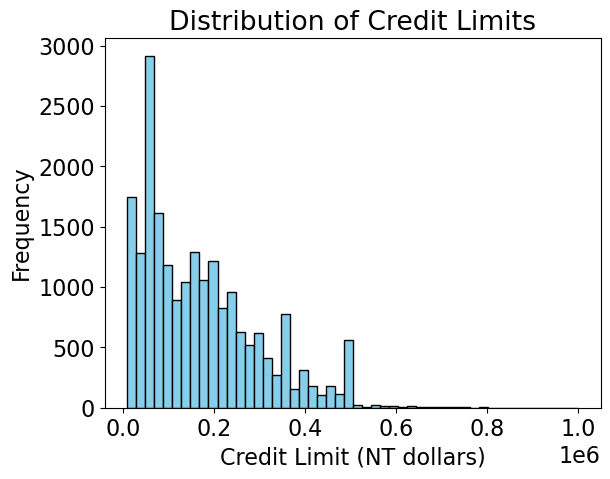

In [75]:
plt.hist(train_set["LIMIT_BAL"], bins = 50, color='skyblue', edgecolor='black')
plt.xlabel("Credit Limit (NT dollars)")
plt.ylabel("Frequency")
plt.title("Distribution of Credit Limits")
plt.show()

For this binary classification task, both false positives and false negatives carry significant consequences. To balance both types of errors, we will use the macro-averaged F1 score as our evaluation metric which equally considers the F1 score for each class, providing a more balanced view of model performance under class imbalance.

<!-- END QUESTION -->

<br><br>


## Feature engineering <a name="4"></a>
<hr>

BILL_AMT and PAY_AMT by themselves don't give the full picture of whether a client is likely to default on payment. For example, a client with a large credit limit may have high BILL_AMT, but that doesn't make them a high risk borrower if they are capable of paying it off (i.e. their PAY_AMT is also high). Therefore, we'll create a new feature DIFF_PCT, which captures the difference between PAY_AMT and BILL_AMT relative to the LIMIT_BAL of the customer.

In [76]:
for i in range(1, 7):
    diff_train = (train_set[f"BILL_AMT{i}"] - train_set[f"PAY_AMT{i}"])
    train_set[f"DIFF_PCT{i}"] = diff_train / train_set["LIMIT_BAL"]

    diff_test = (test_set[f"BILL_AMT{i}"] - test_set[f"PAY_AMT{i}"])
    test_set[f"DIFF_PCT{i}"]  = diff_test / test_set["LIMIT_BAL"]

# Code to loop through features of similar name from https://stackoverflow.com/questions/73187020/how-to-create-new-column-in-function-using-f-string-in-pandas-python

Then, we'll capture the sum of DIFF_PCT_X, where a positive value means the client hasn't fully paid off the credit card debt.

In [77]:
diff_cols = [f"DIFF_PCT{i}" for i in range(1, 7)]

train_set["TOTAL_BALANCE_PCT"] = train_set[diff_cols].sum(axis=1) 
test_set["TOTAL_BALANCE_PCT"]  = test_set[diff_cols].sum(axis=1) 

In [78]:
train_set

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT5,PAY_AMT6,default.payment.next.month,DIFF_PCT1,DIFF_PCT2,DIFF_PCT3,DIFF_PCT4,DIFF_PCT5,DIFF_PCT6,TOTAL_BALANCE_PCT
14451,14452,20000.0,1,3,1,52,-1,-1,-1,-1,...,390.0,780.0,0,0.126100,-0.019500,0.000000,0.000000,0.019500,-0.019500,0.106600
18392,18393,230000.0,2,2,2,24,-1,-1,-1,-1,...,0.0,0.0,1,-0.000335,-0.001517,-0.052500,0.048865,0.004052,0.001378,-0.000057
24955,24956,360000.0,1,3,2,31,1,-1,2,-1,...,0.0,0.0,0,-0.000661,0.000661,-0.009700,0.009806,0.010917,0.010917,0.021939
7162,7163,90000.0,2,2,1,26,2,0,0,0,...,3700.0,3100.0,0,0.943856,0.973656,0.943700,0.939000,0.934600,0.941456,5.676267
12125,12126,20000.0,2,1,2,29,1,2,0,0,...,0.0,300.0,0,0.317250,0.249000,0.334750,0.335350,0.391300,0.362600,1.990250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27165,27166,280000.0,1,2,1,40,1,2,0,0,...,10000.0,5000.0,0,0.850336,0.787582,0.661064,0.554104,0.515789,0.539364,3.908239
3228,3229,50000.0,2,2,1,26,0,0,0,0,...,1300.0,1340.0,0,0.829860,0.791200,0.813440,0.728300,0.688960,0.645820,4.497580
23477,23478,100000.0,2,2,2,30,1,2,0,0,...,0.0,1500.0,1,0.317080,0.290540,0.287530,0.328080,0.349510,0.327610,1.900350
22177,22178,310000.0,2,2,2,27,-1,-1,-1,-1,...,390.0,390.0,1,0.000000,0.000000,-0.001258,0.005326,0.000000,0.000000,0.004068


Based on the PAY_X variables, I'll create a new variable PAY_X_TIER for each PAY_X where I group values {-2, -1, 0} as "good", {1} as "mild delay", {2,3} as "moderate delay", and {4, 5, 6, 7, 8} as "severe delay".

In [79]:
tier_map = {
    -2: 0, -1: 0, 0: 0,          # good (0)
     1: 1,                       # mild delay (1)
     2: 2,  3: 2,                # moderate delay (2)
     4: 3,  5: 3,  6: 3,  7: 3,
     8: 3                       # severe delay (3)
}

pay_cols = [f'PAY_{i}' for i in [0,2,3,4,5,6]]

for col in pay_cols:
    train_set[f'{col}_TIER'] = train_set[col].map(tier_map).astype('int8')
    test_set[f'{col}_TIER'] = test_set[col].map(tier_map).astype('int8')


In [80]:
train_set

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,DIFF_PCT4,DIFF_PCT5,DIFF_PCT6,TOTAL_BALANCE_PCT,PAY_0_TIER,PAY_2_TIER,PAY_3_TIER,PAY_4_TIER,PAY_5_TIER,PAY_6_TIER
14451,14452,20000.0,1,3,1,52,-1,-1,-1,-1,...,0.000000,0.019500,-0.019500,0.106600,0,0,0,0,0,0
18392,18393,230000.0,2,2,2,24,-1,-1,-1,-1,...,0.048865,0.004052,0.001378,-0.000057,0,0,0,0,0,0
24955,24956,360000.0,1,3,2,31,1,-1,2,-1,...,0.009806,0.010917,0.010917,0.021939,1,0,2,0,0,0
7162,7163,90000.0,2,2,1,26,2,0,0,0,...,0.939000,0.934600,0.941456,5.676267,2,0,0,0,0,0
12125,12126,20000.0,2,1,2,29,1,2,0,0,...,0.335350,0.391300,0.362600,1.990250,1,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27165,27166,280000.0,1,2,1,40,1,2,0,0,...,0.554104,0.515789,0.539364,3.908239,1,2,0,0,0,0
3228,3229,50000.0,2,2,1,26,0,0,0,0,...,0.728300,0.688960,0.645820,4.497580,0,0,0,0,0,0
23477,23478,100000.0,2,2,2,30,1,2,0,0,...,0.328080,0.349510,0.327610,1.900350,1,2,0,0,2,2
22177,22178,310000.0,2,2,2,27,-1,-1,-1,-1,...,0.005326,0.000000,0.000000,0.004068,0,0,0,0,0,0


Additionally, we'll create a new variable MAX_TIER that is equal to the highest value among PAY_X_TIER variables. This is to capture the longest time a client has delayed a credit card payment.

In [81]:
tier_cols = [f'PAY_{i}_TIER' for i in [0,2,3,4,5,6]]
train_set["MAX_TIER"] = train_set[tier_cols].max(axis=1).astype('int8')
test_set["MAX_TIER"]  = test_set[tier_cols].max(axis=1).astype('int8')

In [82]:
test_set.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,DIFF_PCT5,DIFF_PCT6,TOTAL_BALANCE_PCT,PAY_0_TIER,PAY_2_TIER,PAY_3_TIER,PAY_4_TIER,PAY_5_TIER,PAY_6_TIER,MAX_TIER
45,46,210000.0,1,1,2,29,-2,-2,-2,-2,...,0.000000,0.000000,0.000000,0,0,0,0,0,0,0
18762,18763,420000.0,2,1,2,29,0,0,0,-2,...,0.000000,-0.200864,-0.043488,0,0,0,0,0,0,0
9341,9342,70000.0,1,2,2,35,0,0,0,0,...,0.547271,0.555614,4.473600,0,0,0,0,0,0,0
21814,21815,180000.0,2,2,2,26,1,-2,-1,-1,...,0.000000,0.000000,0.000000,1,0,0,0,0,0,1
25950,25951,410000.0,2,3,1,32,-2,-2,-2,-2,...,0.249622,0.272995,0.254429,0,0,0,0,0,0,0


<!-- END QUESTION -->

<br><br>


## Preprocessing and transformations <a name="5"></a>
<hr>

I'll drop the ID feature since it is a unique value for each client, and PAY_X features will also not be used since PAY_X_TIER already captures the information. Additionally, I'll standardize the numerical features and perform OneHotEncoding on the categorical features.

In [83]:
numerical_features = ["LIMIT_BAL", "AGE", "TOTAL_BALANCE_PCT", 'DIFF_PCT1', 'DIFF_PCT2', 'DIFF_PCT3', 'DIFF_PCT4', 'DIFF_PCT5', 'DIFF_PCT6']
categorical_features = ["SEX", "MARRIAGE", "EDUCATION"]
ordinal_features = ["PAY_0_TIER", "PAY_2_TIER", "PAY_3_TIER", "PAY_4_TIER", "PAY_5_TIER", "PAY_6_TIER", "MAX_TIER"]
drop = ["ID", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", 
"BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

In [84]:
ord_enc = OrdinalEncoder(
    categories=[[0,1,2,3]]*7,     # PAY_X_TIER * 6 and MAX_TIER
    handle_unknown='use_encoded_value',
    unknown_value = -1
)

ct = make_column_transformer(
    (StandardScaler(), numerical_features),
    ("drop", drop),
    (ord_enc, ordinal_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features)
)

As explained earlier in EDA, we'll be transform the unknown values {0, 5, 6} in EDUCATION into {4}, which means "others".

In [85]:
train_set["EDUCATION"] = train_set["EDUCATION"].replace(to_replace = [0, 5, 6], value = 4)
test_set["EDUCATION"] = test_set["EDUCATION"].replace(to_replace = [0, 5, 6], value = 4)

train_set["EDUCATION"].value_counts()

EDUCATION
2    9875
1    7346
3    3451
4     328
Name: count, dtype: int64

Finally, looking at MARRIAGE, we have an unknown value of 0, so we'll be recoding it into 3, which stands for "others".

In [86]:
train_set["MARRIAGE"].value_counts()

MARRIAGE
2    11125
1     9596
3      242
0       37
Name: count, dtype: int64

In [87]:
train_set["MARRIAGE"] = train_set["MARRIAGE"].replace(to_replace = [0], value = 3)
test_set["MARRIAGE"] = test_set["MARRIAGE"].replace(to_replace = [0], value = 3)

Lets's take a look at our final training set:

In [88]:
train_set.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,DIFF_PCT5,DIFF_PCT6,TOTAL_BALANCE_PCT,PAY_0_TIER,PAY_2_TIER,PAY_3_TIER,PAY_4_TIER,PAY_5_TIER,PAY_6_TIER,MAX_TIER
14451,14452,20000.0,1,3,1,52,-1,-1,-1,-1,...,0.019500,-0.019500,0.106600,0,0,0,0,0,0,0
18392,18393,230000.0,2,2,2,24,-1,-1,-1,-1,...,0.004052,0.001378,-0.000057,0,0,0,0,0,0,0
24955,24956,360000.0,1,3,2,31,1,-1,2,-1,...,0.010917,0.010917,0.021939,1,0,2,0,0,0,2
7162,7163,90000.0,2,2,1,26,2,0,0,0,...,0.934600,0.941456,5.676267,2,0,0,0,0,0,2
12125,12126,20000.0,2,1,2,29,1,2,0,0,...,0.391300,0.362600,1.990250,1,2,0,0,0,2,2


<!-- END QUESTION -->

<br><br>

## Baseline model <a name="6"></a>
<hr>

In [89]:
X_train = train_set.drop(columns = ["default.payment.next.month"])
y_train = train_set["default.payment.next.month"]

X_test = test_set.drop(columns = ["default.payment.next.month"])
y_test = test_set["default.payment.next.month"]

Using the dummy classifier with `parameter strategy = "uniform"`, our baseline model predicts each class with equal probability. Since this is a binary classification problem, there's a 50% chance that the dummy classifier predicts the client will default and a 50% chance of predicting no default.

In [90]:
baseline = DummyClassifier(strategy = "uniform", random_state = 123)
baseline.fit(X_train, y_train)
print("Accuracy: ", baseline.score(X_test, y_test))
print("Macro-Average F1: ", f1_score(y_test, baseline.predict(X_test), average="macro"))

Accuracy:  0.5011111111111111
Macro-Average F1:  0.45837790334105644


As we're uniformly predicting classes, a roughly 0.5 accuracy, recall, and macro-average f1 score is surprising due to the class imbalance. Regardless, the models that we train in the future should achieve higher scores than this.

<!-- END QUESTION -->

<br><br>


## Linear models <a name="7"></a>
<hr>

In [91]:
C = np.logspace(-6, 4, 25)
print(C)

[1.00000000e-06 2.61015722e-06 6.81292069e-06 1.77827941e-05
 4.64158883e-05 1.21152766e-04 3.16227766e-04 8.25404185e-04
 2.15443469e-03 5.62341325e-03 1.46779927e-02 3.83118685e-02
 1.00000000e-01 2.61015722e-01 6.81292069e-01 1.77827941e+00
 4.64158883e+00 1.21152766e+01 3.16227766e+01 8.25404185e+01
 2.15443469e+02 5.62341325e+02 1.46779927e+03 3.83118685e+03
 1.00000000e+04]


In [92]:
from sklearn.metrics import make_scorer

macroAvgF1 = make_scorer(f1_score, average="macro")

In [93]:
scoring = {
    "accuracy": "accuracy",
    "macro_f1": macroAvgF1
}
train_accuracy_scores = []
cv_accuracy_scores = []
train_macroAvgF1_scores = []
cv_macroAvgF1_scores = []
fit_times = []
score_times = []

for c in C:
    pipeline = make_pipeline(ct, LogisticRegression(C = c, random_state = 123, class_weight = "balanced", max_iter = 1000))
    cv_results = cross_validate(pipeline, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring)
    train_mean_accuracy = pd.DataFrame(cv_results["train_accuracy"]).mean()
    train_std_accuracy = pd.DataFrame(cv_results["train_accuracy"]).std()
    test_mean_accuracy = pd.DataFrame(cv_results["test_accuracy"]).mean()
    test_std_accuracy = pd.DataFrame(cv_results["test_accuracy"]).std()
    
    train_mean_macroAvgF1 = pd.DataFrame(cv_results["train_macro_f1"]).mean()
    train_std_macroAvgF1 = pd.DataFrame(cv_results["train_macro_f1"]).std()
    test_mean_macroAvgF1 = pd.DataFrame(cv_results["test_macro_f1"]).mean()
    test_std_macroAvgF1 = pd.DataFrame(cv_results["test_macro_f1"]).std()
    fit_time = pd.DataFrame(cv_results["fit_time"]).mean()
    score_time = pd.DataFrame(cv_results["score_time"]).mean()

    train_accuracy_scores.append((f"%0.3f (+/- %0.3f)" % (train_mean_accuracy.iloc[0], train_std_accuracy.iloc[0])))
    cv_accuracy_scores.append((f"%0.3f (+/- %0.3f)" % (test_mean_accuracy.iloc[0], test_std_accuracy.iloc[0])))
    train_macroAvgF1_scores.append((f"%0.3f (+/- %0.3f)" % (train_mean_macroAvgF1.iloc[0], train_std_macroAvgF1.iloc[0])))
    cv_macroAvgF1_scores.append((f"%0.3f (+/- %0.3f)" % (test_mean_macroAvgF1.iloc[0], test_std_macroAvgF1.iloc[0])))
    fit_times.append(fit_time.iloc[0])
    score_times.append(score_time.iloc[0])

pd.DataFrame({"C value" : C, "Mean Train Accuracy": train_accuracy_scores, "Mean CV Accuracy": cv_accuracy_scores, "Mean Train Macro-Average F1": train_macroAvgF1_scores, "Mean CV Macro-Average F1": cv_macroAvgF1_scores, "Mean Fit Time" : fit_times, "Mean Score Time" : score_times})

,C value,Mean Train Accuracy,Mean CV Accuracy,Mean Train Macro-Average F1,Mean CV Macro-Average F1,Mean Fit Time,Mean Score Time
0,0.000001,0.721 (+/- 0.006),0.720 (+/- 0.012),0.645 (+/- 0.006),0.645 (+/- 0.013),0.031122,0.010193
1,0.000003,0.724 (+/- 0.007),0.724 (+/- 0.012),0.648 (+/- 0.006),0.648 (+/- 0.013),0.028722,0.010003
2,0.000007,0.733 (+/- 0.007),0.732 (+/- 0.010),0.655 (+/- 0.006),0.654 (+/- 0.011),0.030305,0.010008
3,0.000018,0.749 (+/- 0.006),0.748 (+/- 0.008),0.667 (+/- 0.006),0.667 (+/- 0.010),0.028497,0.010216
4,0.000046,0.767 (+/- 0.004),0.768 (+/- 0.010),0.683 (+/- 0.004),0.683 (+/- 0.013),0.031074,0.009960
5,0.000121,0.764 (+/- 0.002),0.763 (+/- 0.009),0.682 (+/- 0.003),0.681 (+/- 0.012),0.032582,0.010448
6,0.000316,0.759 (+/- 0.003),0.759 (+/- 0.009),0.680 (+/- 0.003),0.679 (+/- 0.012),0.031125,0.010366
7,0.000825,0.751 (+/- 0.002),0.750 (+/- 0.008),0.676 (+/- 0.003),0.675 (+/- 0.011),0.031484,0.009996
8,0.002154,0.747 (+/- 0.002),0.747 (+/- 0.007),0.674 (+/- 0.002),0.674 (+/- 0.010),0.037388,0.010266
9,0.005623,0.750 (+/- 0.002),0.749 (+/- 0.007),0.677 (+/- 0.002),0.676 (+/- 0.010),0.038521,0.010557


After trying $25$ different $C$ values ranging from $10^{-6}$ to $10^4$, we find that both cross-validation accuracy and macro-averaged F1 peak at $C=0.000046$, with scores of $0.768$ and $0.683$ respectively. Beyond this point, the metrics plateau, suggesting that additional model complexity (higher C value) does not yield further gains.

<!-- END QUESTION -->

<br><br>


## Other models <a name="8"></a>
<hr>

##### We will try 3 other models: Random Forest (Tree-based ensemble model), KNN, CatBoost (Ensemble model), and LightGBM

### Random Forest

In [94]:
scoring = {
    "accuracy": "accuracy",
    "macro_f1": macroAvgF1
}
random_forest_pipe = make_pipeline(ct, RandomForestClassifier(n_estimators = 100, class_weight = "balanced", bootstrap = True, n_jobs = -1, max_depth = 15, random_state = 123))
random_forest_cv = cross_validate(random_forest_pipe, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(random_forest_cv).mean()

fit_time          0.461685
score_time        0.038350
test_accuracy     0.804667
train_accuracy    0.932548
test_macro_f1     0.692884
train_macro_f1    0.903256
dtype: float64

Performing cross-validation on the Random Forest model with 100 decision trees and a maximum depth of 15, we observe that the training accuracy (0.93) and training macro-F1 (0.90) are much higher than the corresponding cross-validation accuracy (0.80) and macro-F1 (0.69). This large gap suggests that the model is most likely overfitting. Additionally, the fit time (0.51s) and score time (0.039s) are noticeably higher than logistic regression, which is expected given the added complexity of building and averaging over many trees. While Random Forest does achieve higher raw accuracy than logistic regression, its lower macro-F1 indicates it struggles more with class imbalance, so careful hyperparameter tuning may be required.

### K-Neighbors

In [95]:
scoring = {
    "accuracy": "accuracy",
    "macro_f1": macroAvgF1
}
knn_pipe = make_pipeline(ct, KNeighborsClassifier(n_neighbors = 7, n_jobs = -1))
knn_cv = cross_validate(knn_pipe, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(knn_cv).mean()

fit_time          0.023350
score_time        0.087774
test_accuracy     0.802143
train_accuracy    0.832333
test_macro_f1     0.658651
train_macro_f1    0.710779
dtype: float64

Performing cross-validation on the KNN classifier with $k=7$, we observe that the training accuracy ($0.83$) and macro-F1 ($0.71$) are only slightly higher than the corresponding cross-validation accuracy ($0.80$) and macro-F1 ($0.66$). This relatively small gap indicates that the model is not strongly overfitting, but the overall macro-F1 score is lower than both logistic regression and random forest, suggesting that KNN is struggling with class imbalance and capturing minority class patterns. The fit time $0.026$ s is very fast, but the scoring time $0.14$ s is slower than logistic regression due to KNN’s instance-based nature, where predictions require distance computations against the entire training set. Overall, KNN underperforms the tree-based and linear models in terms of balanced classification ability.

### CatBoost

In [96]:
neg_pos_class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
neg_pos_class_ratio

np.float64(3.5209903121636166)

In [97]:
scoring = {
    "accuracy": "accuracy",
    "macro_f1": macroAvgF1
}
catboost_pipe = make_pipeline(ct, CatBoostClassifier(verbose = 0, random_state = 123, scale_pos_weight = neg_pos_class_ratio))
catboost_cv = cross_validate(catboost_pipe, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(catboost_cv).mean()

fit_time          5.827677
score_time        0.039524
test_accuracy     0.760048
train_accuracy    0.834536
test_macro_f1     0.682079
train_macro_f1    0.783981
dtype: float64

Performing cross-validation on the CatBoost model, we observe a training accuracy of $0.83$ and macro-F1 of $0.78$, compared to cross-validation accuracy of $0.76$ and macro-F1 of $0.68$. This gap suggests some degree of overfitting, though the cross-validation performance is still competitive with logistic regression and KNN models. CatBoost achieves one of the higher macro-F1 scores, but this comes at the cost of higher computational time: the fit time (**7.1s**) is much larger than the other models. Overall, CatBoost shows strong predictive ability even without hyperparameter tuning, though overfitting risk should be considered.

### LightGBM

In [98]:
import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
# Reference: Code from CPSC 330 lecture 12 to suppress warning

In [99]:
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123, verbose=-1, class_weight = "balanced"))
lgbm_cv = cross_validate(pipe_lgbm, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(lgbm_cv).mean()

fit_time          0.119292
score_time        0.015217
test_accuracy     0.758429
train_accuracy    0.820607
test_macro_f1     0.683399
train_macro_f1    0.766840
dtype: float64

Performing cross-validation on the LightGBM model, we observe a training accuracy of **0.82** and macro-F1 of **0.77**, compared to cross-validation accuracy of **0.76** and macro-F1 of **0.68**. While there is a moderate gap between training and validation scores that suggests some overfitting, the overall cross-validation performance is among the strongest we have seen so far. Importantly, LightGBM achieves this with a much lower computational cost: the fit time (**0.17s**) and score time (**0.019s**) are significantly faster than CatBoost. 

<!-- END QUESTION -->

<br><br>


## Feature selection <a name="9"></a>
<hr>

In an attempt to figure out the relevant features, we will be using sklearn's Recursive feature elimination with cross-validation (RFECV) with LightGBM model, specifically optimizing for the macro-average f1 metric.

In [100]:
X_train_preproceesed = ct.fit_transform(X_train)
rfe_cv = RFECV(LGBMClassifier(random_state=123, verbose=-1, class_weight = "balanced"), scoring = macroAvgF1)
rfe_cv.fit(X_train_preproceesed, y_train)
print(rfe_cv.support_)
# Code from CPSC 330 lecture 14

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True False False  True  True  True
  True]


In [101]:
column_names = (
    numerical_features
    + ordinal_features
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
# Code adapted from CPSC 330 lecture 6

In [102]:
selected_features = np.array(column_names)[rfe_cv.support_].tolist()
print(selected_features)

['LIMIT_BAL', 'AGE', 'TOTAL_BALANCE_PCT', 'DIFF_PCT1', 'DIFF_PCT2', 'DIFF_PCT3', 'DIFF_PCT4', 'DIFF_PCT5', 'DIFF_PCT6', 'PAY_0_TIER', 'PAY_2_TIER', 'PAY_3_TIER', 'PAY_4_TIER', 'PAY_5_TIER', 'PAY_6_TIER', 'MAX_TIER', 'SEX_1', 'MARRIAGE_1', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4']


In [103]:
print("Number of features select: ", len(selected_features))
print("Number of total features: ", len(rfe_cv.support_))

Number of features select:  22
Number of total features:  25


As shown above, we've gone down from 25 to 23 features. These are the relevant features that RFECV found to give the highest macro-average f1 score for the LightGBM model.

Now, let's see how the models would perform using these set of features.

In [104]:
X_train_transformed = ct.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns = column_names)
X_train_transformed_df = X_train_transformed_df[selected_features]
X_train_transformed_df.head()

,LIMIT_BAL,AGE,TOTAL_BALANCE_PCT,DIFF_PCT1,DIFF_PCT2,DIFF_PCT3,DIFF_PCT4,DIFF_PCT5,DIFF_PCT6,PAY_0_TIER,...,PAY_4_TIER,PAY_5_TIER,PAY_6_TIER,MAX_TIER,SEX_1,MARRIAGE_1,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
0,-1.136839,1.790069,-0.925528,-0.606116,-0.913872,-0.877366,-0.858280,-0.789448,-0.857962,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.480315,-1.245504,-0.977519,-0.910392,-0.871163,-1.007383,-0.729142,-0.833043,-0.798895,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.481411,-0.486611,-0.966797,-0.911178,-0.865989,-0.901389,-0.832366,-0.813671,-0.771910,1.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.597787,-1.028677,1.789449,1.361886,1.444921,1.459719,1.623260,1.793011,1.860692,2.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-1.136839,-0.703437,-0.007329,-0.146096,-0.276172,-0.048354,0.027966,0.259790,0.223043,1.0,...,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0


In [105]:
RF_selected = RandomForestClassifier(n_estimators = 100, class_weight = "balanced", bootstrap = True, n_jobs = -1, max_depth = 15, random_state = 123)
RF_cv = cross_validate(RF_selected, X_train_transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(RF_cv).mean()

fit_time          0.431132
score_time        0.033200
test_accuracy     0.805333
train_accuracy    0.927702
test_macro_f1     0.695300
train_macro_f1    0.896257
dtype: float64

In [106]:
catboost = CatBoostClassifier(verbose = 0, random_state = 123, scale_pos_weight = neg_pos_class_ratio)
catboost_cv = cross_validate(catboost, X_train_transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(catboost_cv).mean()

fit_time          5.801418
score_time        0.007002
test_accuracy     0.761619
train_accuracy    0.834905
test_macro_f1     0.684019
train_macro_f1    0.784154
dtype: float64

In [107]:
lgbm = LGBMClassifier(random_state=123, verbose=-1, class_weight = "balanced")
lgbm_cv = cross_validate(lgbm, X_train_transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(lgbm_cv).mean()

fit_time          0.104201
score_time        0.009020
test_accuracy     0.758810
train_accuracy    0.820071
test_macro_f1     0.683711
train_macro_f1    0.765868
dtype: float64

In [108]:
lr = LogisticRegression(random_state = 123, class_weight = "balanced")
lr_cv = cross_validate(lr, X_train_transformed_df, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(lr_cv).mean()

fit_time          0.021900
score_time        0.004129
test_accuracy     0.751667
train_accuracy    0.753143
test_macro_f1     0.676604
train_macro_f1    0.678227
dtype: float64

Comparing these results of random forest, catboost, lightgbm, and logistic regression models with their original score that uses all 25 features, the cross-validation macro f1 scores appears to be roughly the same. Therefore, we will continue to use all 25 features for simplicity.

<!-- END QUESTION -->

<br><br>

## Hyperparameter optimization <a name="10"></a>
<hr>

I will make an attempt to optimize hyperparameters for the models that I've tried. Let's first define a function to help perform and showcase results of GridSearchCV.

In [109]:
scoring = {
    "accuracy": "accuracy",
    "macro_f1": macroAvgF1,
}

def grid_search_cv(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(
        pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring = scoring, refit = "macro_f1"
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    return results
# Adapted from lecture 8's display_heatmap function


def my_heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    ax.set_title("Macro-Average F1 Heatmap")

    
    iteration = 0
    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array().flatten()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'        
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img
# Code from cpsc330-2024W2/lectures/code/plotting_functions.py

### Optimizing hyperparameters for Random Forest

In [110]:
random_forest_param_grid = {
    "randomforestclassifier__max_depth": [3, 9, 15, 21, 30],
    "randomforestclassifier__max_features": [3, 5, 10, 20, 30],
}
RF_pipe = make_pipeline(ct, RandomForestClassifier(n_estimators = 40, class_weight = "balanced", bootstrap = True, n_jobs = -1, random_state = 123))
random_forest_result = grid_search_cv(random_forest_param_grid, RF_pipe, X_train, y_train)
# Adapted from lecture 8

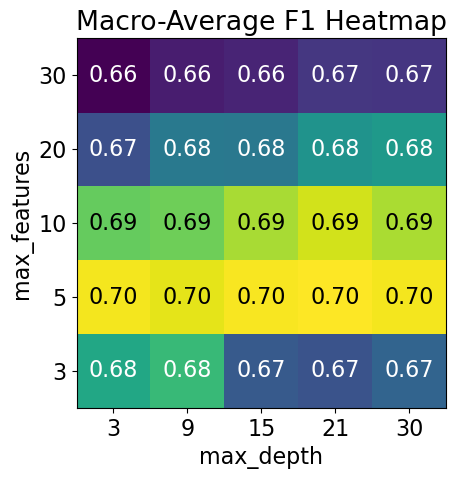

In [111]:
scores = np.array(random_forest_result.mean_test_macro_f1).reshape(5, 5)

# plot the mean cross-validation scores
my_heatmap(
    scores,
    xlabel="max_depth",
    xticklabels=random_forest_param_grid["randomforestclassifier__max_depth"],
    ylabel="max_features",
    yticklabels=random_forest_param_grid["randomforestclassifier__max_features"],
    cmap="viridis",
);
# Adapted from lecture 8

From the heatmap, the highest macro-F1 score (~0.70) occurs consistently when max_features = 5, regardless of tree depth. Since deeper trees don’t add improvement, choosing max_features = 5 with a moderate max_depth = 9 gives strong performance while helping control overfitting and fit time.

### Optimizing hyperparameter for K-Nearest-Neighbors

In [112]:
knn_param_grid = {"kneighborsclassifier__n_neighbors": np.arange(3, 42, 6)}
knn_cv_scores = grid_search_cv(knn_param_grid, knn_pipe, X_train, y_train)

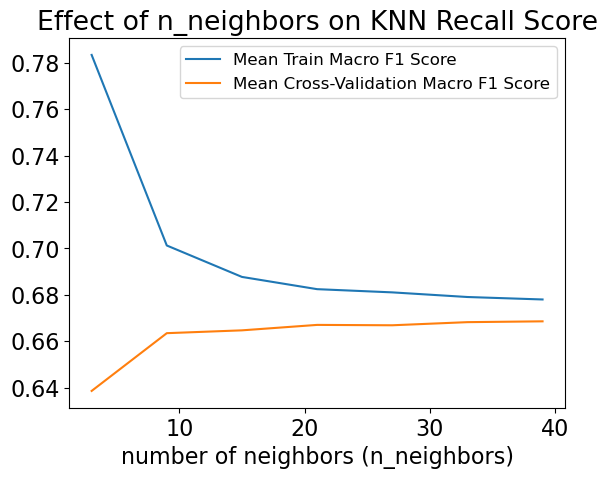

In [113]:
plt.plot(knn_cv_scores["param_kneighborsclassifier__n_neighbors"], knn_cv_scores["mean_train_macro_f1"], label = "Mean Train Macro F1 Score")
plt.plot(knn_cv_scores["param_kneighborsclassifier__n_neighbors"], knn_cv_scores["mean_test_macro_f1"], label = "Mean Cross-Validation Macro F1 Score")
plt.xlabel("number of neighbors (n_neighbors)")
plt.title("Effect of n_neighbors on KNN Recall Score")
plt.legend(fontsize = 12)
plt.show()
# Adapted from cpsc330-2024W2/docs/python_notes.html "Plotting with matplotlib"

From the KNN hyperparameter search, we see that the cross-validation F1 score improves from \(n=3\) and stabilizes around \(n=15–20\). Since larger $n$ values smooth decision boundaries and help reduce variance without much loss in performance, selecting around \(n=15\) provides a good balance between bias and variance.

### Optimizing hyperparameters for CatBoost

In [114]:
catboost_param_grid = {
    "catboostclassifier__learning_rate": [0.01, 0.05, 0.1, 0.5, 0.9],
    "catboostclassifier__max_depth": [2, 3, 4, 6, 8],
}
catboost_model = make_pipeline(ct, CatBoostClassifier(verbose = 0, random_state = 123, iterations = 200, early_stopping_rounds = 70, scale_pos_weight = neg_pos_class_ratio))
catboost_result = grid_search_cv(catboost_param_grid, catboost_model, X_train, y_train)

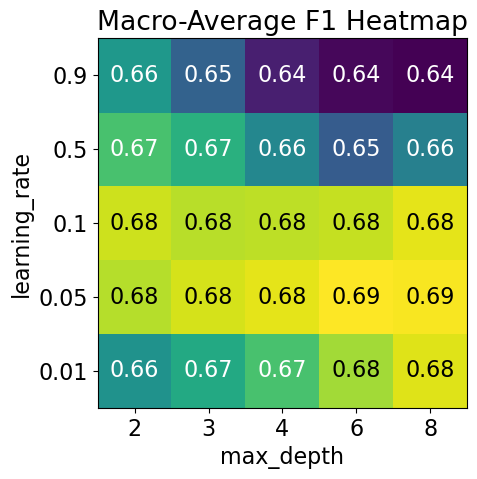

In [115]:
scores = np.array(catboost_result.mean_test_macro_f1).reshape(5, 5)

my_heatmap(
    scores,
    xlabel="max_depth",
    xticklabels=catboost_param_grid["catboostclassifier__max_depth"],
    ylabel="learning_rate",
    yticklabels=catboost_param_grid["catboostclassifier__learning_rate"],
    cmap="viridis",
);
# Adapted from lecture 8

From the CatBoost hyperparameter heatmap, we see that the best macro-average F1 scores (around 0.69) occur at a learning rate of 0.05 with max_depth values of 6 or 8. Since both depth 6 and 8 give similar results, choosing a max_depth of 6 with a learning rate of 0.05 provides a good balance between performance and model complexity.


In [116]:
scoring = {
    "accuracy": "accuracy",
    "macro_f1": macroAvgF1
}

lgbm_param_grid = {
    "lgbmclassifier__max_depth": [3, 5, 7, 9, 12],  
    "lgbmclassifier__num_leaves": [10, 20, 30, 50],  
    "lgbmclassifier__learning_rate": [0.01, 0.05, 0.1, 0.2], 
    "lgbmclassifier__n_estimators": [100, 300, 500, 1000],  
    "lgbmclassifier__min_child_samples": [10, 20, 50, 100], 
    "lgbmclassifier__colsample_bytree": [0.5, 0.7, 0.9, 1.0], 
    "lgbmclassifier__subsample": [0.6, 0.8, 1.0], 
    "lgbmclassifier__reg_alpha": [0, 0.1, 1, 10],
    "lgbmclassifier__reg_lambda": [0, 0.1, 1, 10], 
}

pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123, verbose=-1, class_weight = "balanced"))
random_search = RandomizedSearchCV(pipe_lgbm, lgbm_param_grid, n_jobs = -1, n_iter = 150, return_train_score = True, scoring = scoring, refit = "macro_f1", random_state = 123)
random_search.fit(X_train, y_train)
# List of lightgbm parameters from https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'TOTAL_BALANCE_PCT',
                                                                                'DIFF_PCT1',
                                                                                'DIFF_PCT2',
                                                                                'DIFF_PCT3',
                                                                                'DIFF_PCT4',
                                                                                'DIFF_PCT5',
                                                                                'DIFF_PCT6']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['ID',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3'...
                                        'lgbmclassifier__n_estimators': [100,
                                                                         300,
                                                                         500,
                                                                         1000],
                                        'lgbmclassifier__num_leaves': [10, 20,
                                                                       30, 50],
                                        'lgbmclassifier__reg_alpha': [0, 0.1, 1,
                                                                      10],
                                        'lgbmclassifier__reg_lambda': [0, 0.1,
                                                                       1, 10],
                                        'lgbmclassifier__subsample': [0.6, 0.8,
                                                                      1.0]},
                   random_state=123, refit='macro_f1', return_train_score=True,
                   scoring={'accuracy': 'accuracy',
                            'macro_f1': make_scorer(f1_score, response_method='predict', average=macro)})

In [117]:
random_search.best_score_

np.float64(0.6889998826682364)

Performing RandomizedSearchCV on the LightGBM classifier, the highest cross-validation macro-average f1 score is 0.69, with the parameters of LightGBM being:

In [118]:
random_search.best_params_

{'lgbmclassifier__subsample': 0.8,
 'lgbmclassifier__reg_lambda': 10,
 'lgbmclassifier__reg_alpha': 0,
 'lgbmclassifier__num_leaves': 30,
 'lgbmclassifier__n_estimators': 100,
 'lgbmclassifier__min_child_samples': 10,
 'lgbmclassifier__max_depth': 7,
 'lgbmclassifier__learning_rate': 0.01,
 'lgbmclassifier__colsample_bytree': 0.9}


## Examining feature importances <a name="11"></a>
<hr>

Let's perform SHAP (SHapley Additive exPlanations) on LightGBM classifier with the best parameters we found in RandomizedSearchCV.

In [119]:
X_train_enc = pd.DataFrame(
    data=ct.fit_transform(X_train),
    columns=column_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=ct.transform(X_test),
    columns=column_names,
    index=X_test.index,
)
# Adapted from CPSC 330 lecture 13

In [120]:
model = LGBMClassifier(random_state=123, verbose=-1, class_weight = "balanced", colsample_bytree = 0.9, learning_rate = 0.01, max_depth = 5, 
                       min_child_samples = 20, n_estimators = 500, num_leaves = 10, reg_alpha = 0, reg_lambda = 10, subsample = 1.0)
model.fit(X_train_enc, y_train)
# Adapted from CPSC 330 lecture 13

LGBMClassifier(class_weight='balanced', colsample_bytree=0.9,
               learning_rate=0.01, max_depth=5, n_estimators=500, num_leaves=10,
               random_state=123, reg_alpha=0, reg_lambda=10, verbose=-1)

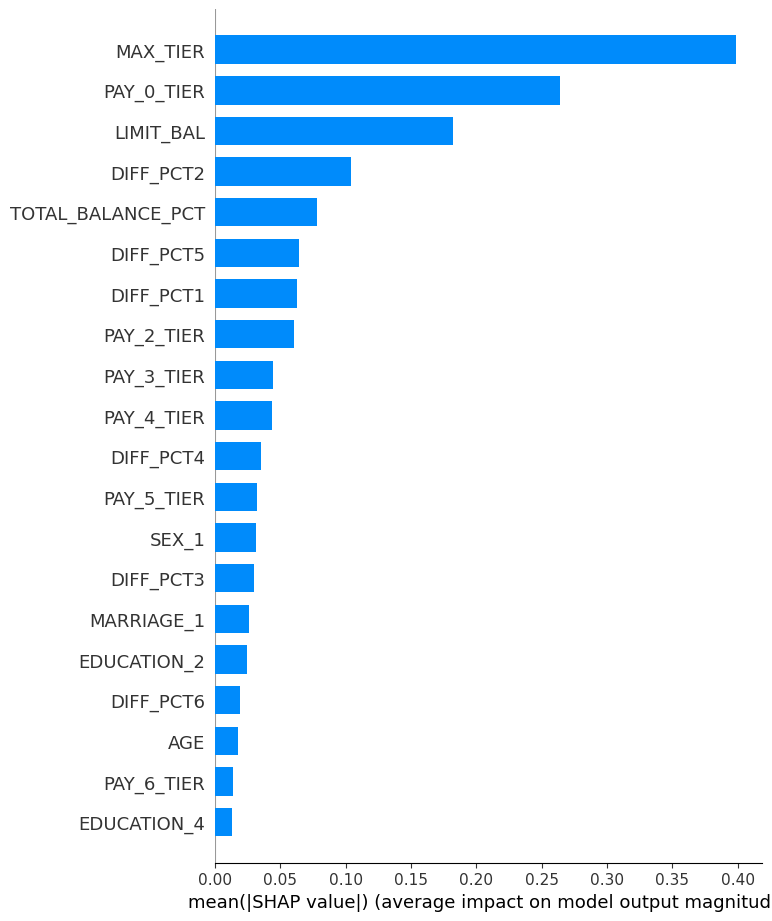

In [121]:
explainer = shap.TreeExplainer(model) # define the shap explainer 
train_shap_values = explainer(X_train_enc) # train shap values
test_shap_values = explainer(X_test_enc) # test shap values 
shap.summary_plot(train_shap_values, X_train_enc, plot_type="bar")
# Adapted from CPSC 330 lecture 13

The SHAP summary plot shows that MAX_TIER, PAY_0_TIER, and LIMIT_BAL are the most influential features, with balance difference features (DIFF_PCTx) and TOTAL_BALANCE_PCT also contributing moderately. These results suggest that repayment status and balance dynamics are the primary drivers of the model’s predictions. In contrast, demographic variables such as EDUCATION, SEX, and AGE have much smaller SHAP values, indicating they have limited direct impact, though their influence may still be captured indirectly through correlations with other features.

<!-- END QUESTION -->

<br><br>


## Results on the test set <a name="12"></a>
<hr>

In [122]:
best_model = RandomForestClassifier(n_estimators = 40, class_weight = "balanced", bootstrap = True, n_jobs = -1, random_state = 123, max_depth = 9, max_features = 5)
best_model_cv = cross_validate(best_model, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring)
pd.DataFrame(best_model_cv).mean()

fit_time          0.198114
score_time        0.020139
test_accuracy     0.781571
train_accuracy    0.828202
test_macro_f1     0.696377
train_macro_f1    0.761494
dtype: float64

Using the optimized Random Forest model, cross-validation achieved a mean accuracy of about 0.78 with a macro F1 score of 0.7, which is consistent with the performance on the testing set (accuracy ≈ 0.78, macro F1 ≈ 0.70) as seen below. This indicates that the model generalizes well and is not heavily overfitting, as the cv and test scores are close.

In [123]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Macro-Average F1 score: ", f1_score(y_test, y_pred, average = "macro"))
print("Accuracy: ", best_model.score(X_test, y_test))

Macro-Average F1 score:  0.6943836693488175
Accuracy:  0.7805555555555556


## Summary of results <a name="13"></a>
<hr>

The table below summarizes the Accuracy and Macro-Average F1 scores for different models when evaluated on the **testing set**. The scores for LightGBMClassifier, CatBoostClassifier, and LogisticRegression were calculated using the best-performing hyperparameter values found during hyperparameter tuning, but the evaluation steps on the testing set are not shown here.

In [124]:
model_names = ["LightGBMClassifier", "CatBoostClassifier", "RandomForestClassifier", "LogisticRegression", "KNNClassifier"]
results_summary = {
    "Accuracy": [0.754, 0.761, 0.780, 0.703, 0.777],
    "Macro-Average F1": [0.682, 0.689, 0.694, 0.639, 0.520],
}
pd.DataFrame(results_summary, index = model_names)

,Accuracy,Macro-Average F1
LightGBMClassifier,0.754,0.682
CatBoostClassifier,0.761,0.689
RandomForestClassifier,0.780,0.694
LogisticRegression,0.703,0.639
KNNClassifier,0.777,0.520


The results show that the Random Forest Classifier performed best overall, with the highest accuracy (0.780) and macro-average F1 score (0.694). Both CatBoost and LightGBM also gave strong results, with similar F1 scores around 0.68–0.69, showing that tree-based ensemble methods also work well for this task. In contrast, Logistic Regression struggled, with lower accuracy and F1, while KNN had high accuracy but a poor F1 score, showing it did not handle the class imbalance well.

Looking at model performance table, if all four models are returning suboptimal macro-average f1 scores, then the problem likely lies in the preprocessing steps. Looking back, there are several aspects that I could have approached differently. For example, instead of relying on setting `class_weight = 'balanced'` during model training to deal with the class imbalance, I should have also attempted at modifying the training set itself by either undersampling or oversampling. Additionally, perhaps I could've came up with more useful features and tested a wider range of hyperparameter values. However, there are also some errors in the dataset itself, such as lack of documentation for some feature values. For instance, PAY_X refers to if the client has paid that month, but values like -2 and 0 were not documented despite appearing frequently.

## Takeaway <a name="14"></a>
<hr>

My biggest takeaway is that building a strong supervised machine learning model is a lot harder than it seems, with many layers beyond just picking a powerful algorithm. For example, complex models like LightGBM or CatBoost won’t perform well if the input data isn’t properly prepared. This made it clear to me how important preprocessing, feature engineering, and thorough hyperparameter tuning really are for achieving good results.

Through this project, I also came to appreciate efficiency techniques such as early stopping, feature selection, and parallel processing, which made a huge difference when dealing with the long run times of training, cross-validation, and hyperparameter tuning. At times it was frustrating when model performance did not improve despite multiple preprocessing attempts, but overall these processes reinforced my understanding of the concepts we covered in CPSC 330 (Applied ML) and gave me a better sense of how challenging and rewarding machine learning can be.